In [1]:
# This is code for cz4042 final project
# Speech emotion recognition

# Keras
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses, models, optimizers
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import SGD
# Other
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from matplotlib.pyplot import specgram
import pandas as pd
import os
import sys
import warnings
import pickle
# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
# To mount google drive when using colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path for input files in google drive mounted
path = '/content/drive/My Drive/Colab Notebooks/inputs/'

In [6]:
# load dataset
win_ts = 128
hop_ts = 64
only_radvess = True

melspec = np.load(path + 'mel_spec_data_1.npy')
ref = pd.read_pickle(path + "data_df_1.pkl")

In [7]:
# for test data loaded, commented after test
#print(melspec.shape)
# print(melspec)

(4320, 25920)


In [8]:
# print(ref.head)

<bound method NDFrame.head of      Emotion  ...                                               Path
0          5  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
1          6  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
2          6  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
3          5  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
4          7  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
...      ...  ...                                                ...
4315       2  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_08/03...
4316       2  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_08/03...
4317       2  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_08/03...
4318       1  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_08/03...
4319       1  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_08/03...

[4320 rows x 4 columns]>


In [9]:
# Split between train and test data, ratio of 1:3
X_train, X_test, y_train, y_test = train_test_split(
    melspec, ref.Emotion, test_size=0.25, shuffle=True, random_state=42)

X_train = X_train.squeeze()
X_test = X_test.squeeze()
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(X_train.shape)

(3240, 25920)


In [ ]:
# for test only
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [10]:
# Reshape X train and test, for input into model, reshape the data being flattend in feature extraction part in order to easier save
X_train = X_train.reshape(3240, 2, 1, 60, 216)
X_test = X_test.reshape(1080, 2, 1, 60, 216)

input_y = Input(shape=X_train.shape[1:], name='Input_MELSPECT')

# for test only
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3240, 2, 1, 60, 216)
(1080, 2, 1, 60, 216)
(3240, 8)
(1080, 8)


In [11]:
# Check the device used for training is GPU 
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))

Selected device is cuda


In [23]:
# Model Disign

## First LFLB (local feature learning block)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_1')(input_y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_1')(y)
y = TimeDistributed(Activation('elu'), name='Activ_1')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'), name='MaxPool_1')(y)
y = TimeDistributed(Dropout(0.3), name='Drop_1')(y)     

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_2')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_2')(y)
y = TimeDistributed(Activation('elu'), name='Activ_2')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_2')(y)
y = TimeDistributed(Dropout(0.3), name='Drop_2')(y)


## Third LFLB (local feature learning block)
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_3')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_3')(y)
y = TimeDistributed(Activation('elu'), name='Activ_3')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_3')(y)
y = TimeDistributed(Dropout(0.4), name='Drop_3')(y)

## Fourth LFLB (local feature learning block)
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_4')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_4')(y)
y = TimeDistributed(Activation('elu'), name='Activ_4')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_4')(y)
y = TimeDistributed(Dropout(0.4), name='Drop_4')(y)  

## Flat
y = TimeDistributed(Flatten(), name='Flat')(y)                      

## Dense layer                            

y = Flatten()(y)
y = Dense(64)(y)
y = Dropout(rate=0.5)(y)
y = BatchNormalization()(y)
y = Activation("relu")(y)
y = Dropout(rate=0.5)(y)

y = Dense(y_train.shape[1], activation='softmax', name='FC')(y)

model = Model(inputs=input_y, outputs=y)

model.compile(optimizer=Adam(lr=0.005, decay=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, verbose=1, mode='max')

# Fit model
# history = model.fit(X_train, y_train, batch_size=64, epochs=1, validation_data=(X_test, y_test), callbacks=[early_stopping])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                              batch_size=64, verbose=2, epochs=1500)

Epoch 1/1500
51/51 - 1s - loss: 2.3607 - accuracy: 0.1417 - val_loss: 6.1713 - val_accuracy: 0.1241
Epoch 2/1500
51/51 - 1s - loss: 2.1071 - accuracy: 0.1531 - val_loss: 2.2586 - val_accuracy: 0.1481
Epoch 3/1500
51/51 - 1s - loss: 2.0306 - accuracy: 0.1997 - val_loss: 1.9487 - val_accuracy: 0.2824
Epoch 4/1500
51/51 - 1s - loss: 1.9562 - accuracy: 0.2324 - val_loss: 1.8494 - val_accuracy: 0.2676
Epoch 5/1500
51/51 - 1s - loss: 1.8938 - accuracy: 0.2593 - val_loss: 1.7963 - val_accuracy: 0.2843
Epoch 6/1500
51/51 - 1s - loss: 1.8383 - accuracy: 0.2938 - val_loss: 1.7352 - val_accuracy: 0.3167
Epoch 7/1500
51/51 - 1s - loss: 1.8133 - accuracy: 0.3046 - val_loss: 1.6857 - val_accuracy: 0.3667
Epoch 8/1500
51/51 - 1s - loss: 1.7879 - accuracy: 0.3015 - val_loss: 1.6068 - val_accuracy: 0.3704
Epoch 9/1500
51/51 - 1s - loss: 1.7589 - accuracy: 0.3238 - val_loss: 1.6190 - val_accuracy: 0.3704
Epoch 10/1500
51/51 - 1s - loss: 1.7183 - accuracy: 0.3441 - val_loss: 1.7801 - val_accuracy: 0.3213

In [42]:
# Save accuracy to npy file for further use
np.save(path + 'cnn_acc_1.npy', np.array(history.history['accuracy'],dtype=None))

In [43]:
# test only
acc = np.load(path + 'cnn_acc_1.npy')
print(acc)

[       nan        nan        nan ... 0.9015849  0.90163956 0.90163641]


In [28]:
# Save val_accuracy to npy file for further use
np.save(path + 'cnn_accval_1.npy', np.array(history.history['val_accuracy']))

In [29]:
# test only
valacc = np.load(path + 'cnn_accval_1.npy')
print(valacc)
print(valacc.shape)

[       nan        nan        nan ... 0.91666667 0.91222223 0.91268519]
(1500,)


In [30]:
# Save loss to npy file for further use
np.save(path + 'cnn_lss_1.npy', np.array(history.history['loss']))

In [31]:
# test only
lss = np.load(path + 'cnn_lss_1.npy')
print(lss)
print(lss.shape)

[       nan        nan        nan ... 0.29629613 0.29876105 0.29746486]
(1500,)


In [32]:
# Save val_loss to npy file for further use
np.save(path + 'cnn_vallss_1.npy', np.array(history.history['val_loss']))

In [33]:
# test only
vallss = np.load(path + 'cnn_vallss_1.npy')
print(vallss)
print(vallss.shape)

[       nan        nan        nan ... 0.29206136 0.29911602 0.29338127]
(1500,)


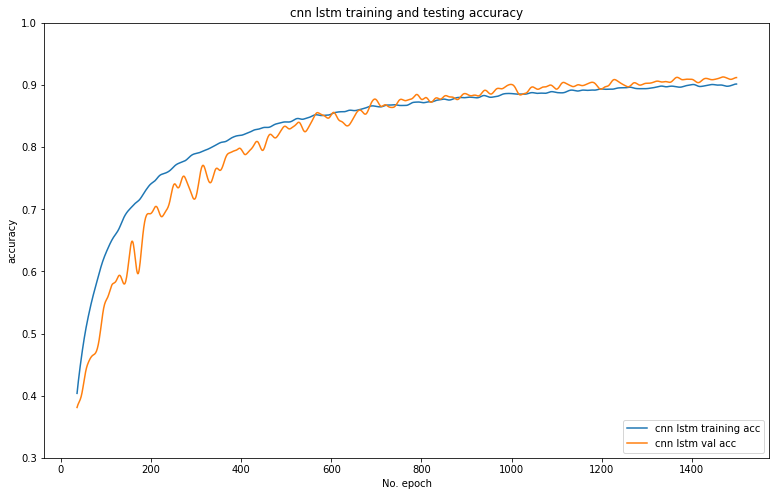

In [39]:
# plot curves - cnn training and test accuracy
fig=plt.gcf()

history.history['accuracy'] = pd.Series(history.history['accuracy']).rolling(window=10).mean()
history.history['val_accuracy'] = pd.Series(history.history['val_accuracy']).rolling(window=10).mean()

axes = plt.gca()
axes.set_ylim([0.3,1])

plt.plot(history.history['accuracy'], label='cnn training acc', c='#1f77b4')
plt.plot(history.history['val_accuracy'], label='cnn val acc', c='#ff7f0e')

plt.title('cnn training and testing accuracy')
plt.ylabel('accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")

fig.set_size_inches(13, 8, forward=True)
plt.show()

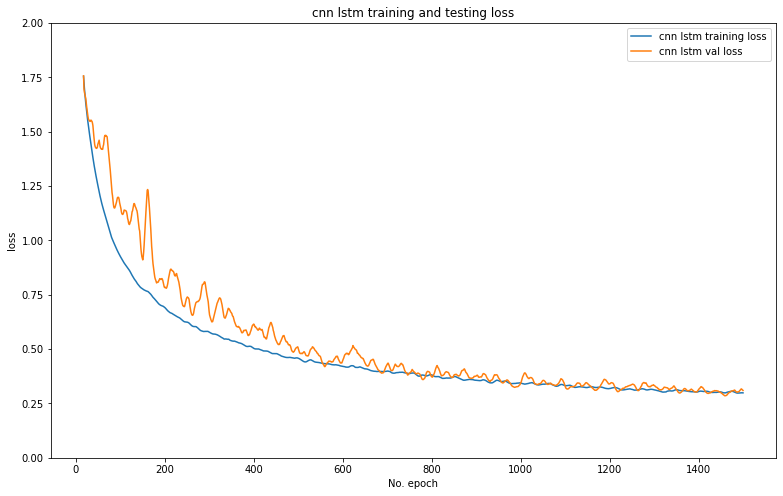

In [40]:
# plot curves - cnn training and test loss
fig=plt.gcf()

axes = plt.gca()
axes.set_ylim([0,2])

history.history['loss'] = pd.Series(history.history['loss']).rolling(window=10).mean()
history.history['val_loss'] = pd.Series(history.history['val_loss']).rolling(window=10).mean()

plt.plot(history.history['loss'], label='cnn training loss', c='#1f77b4')
plt.plot(history.history['val_loss'], label='cnn val loss', c='#ff7f0e')

plt.title('cnn training and testing loss')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")

fig.set_size_inches(13, 8, forward=True)
plt.show()

In [46]:
# Load val acc of model with lstm and attention, and test data loaded
attvalacc = np.load(path + 'att_accval.npy')
print(attvalacc)
print(attvalacc.shape)

[0.14259259 0.13518518 0.19259259 ... 0.95833331 0.96574074 0.96203703]
(1500,)


In [47]:
# Load val acc of model with lstm, and test data loaded
lstmvalacc = np.load(path + 'lstm_accval.npy')
print(lstmvalacc)
print(lstmvalacc.shape)

[0.11574074 0.16203703 0.25370371 ... 0.96296299 0.96666664 0.96018517]
(1500,)


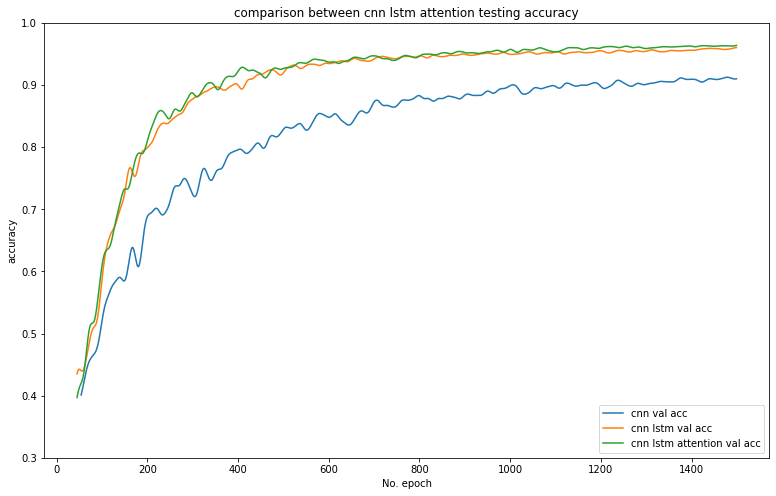

In [54]:
# plot curves - comparison between cnn, cnn lstm, cnn lstm attention testing accuracy
fig=plt.gcf()

valacc = pd.Series(valacc).rolling(window=10).mean()
lstmvalacc = pd.Series(lstmvalacc).rolling(window=10).mean()
attvalacc = pd.Series(attvalacc).rolling(window=10).mean()

axes = plt.gca()
axes.set_ylim([0.3,1])

plt.plot(valacc, label='cnn val acc', c='#1f77b4')
plt.plot(lstmvalacc, label='cnn lstm val acc', c='#ff7f0e')
plt.plot(attvalacc, label='cnn lstm attention val acc', c='C2')

plt.title('comparison between cnn lstm attention testing accuracy')
plt.ylabel('accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")

fig.set_size_inches(13, 8, forward=True)
plt.show()

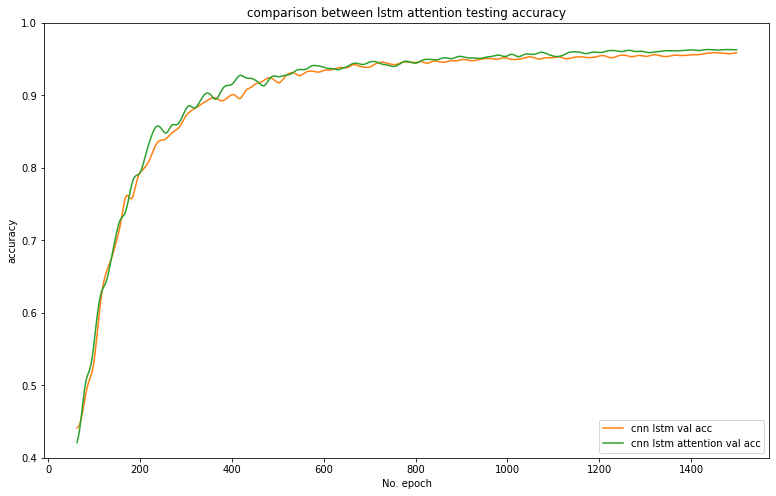

In [56]:
# plot curves - comparison between cnn lstm, cnn lstm attention testing accuracy
fig=plt.gcf()

# valacc = pd.Series(valacc).rolling(window=10).mean()
lstmvalacc = pd.Series(lstmvalacc).rolling(window=10).mean()
attvalacc = pd.Series(attvalacc).rolling(window=10).mean()

axes = plt.gca()
axes.set_ylim([0.4,1])

# plt.plot(valacc, label='cnn val acc', c='#1f77b4')
plt.plot(lstmvalacc, label='cnn lstm val acc', c='#ff7f0e')
plt.plot(attvalacc, label='cnn lstm attention val acc', c='C2')

plt.title('comparison between lstm attention testing accuracy')
plt.ylabel('accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")

fig.set_size_inches(13, 8, forward=True)
plt.show()

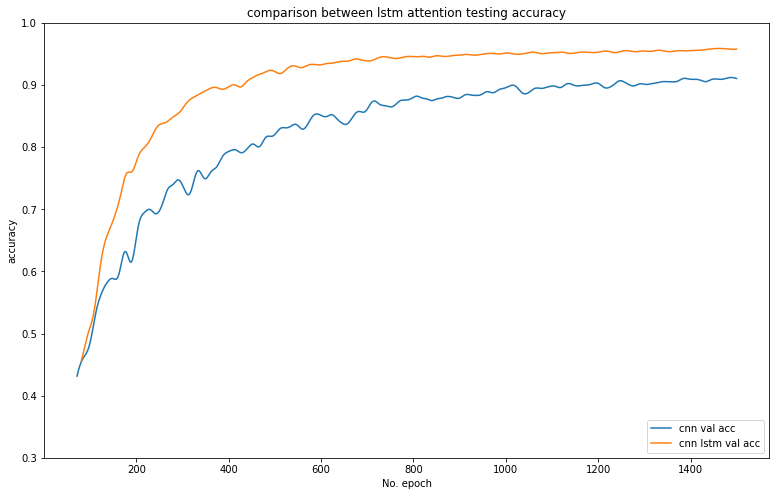

In [58]:
# plot curves - comparison between cnn , cnn lstm attention testing accuracy
fig=plt.gcf()

valacc = pd.Series(valacc).rolling(window=10).mean()
lstmvalacc = pd.Series(lstmvalacc).rolling(window=10).mean()
# attvalacc = pd.Series(attvalacc).rolling(window=10).mean()

axes = plt.gca()
axes.set_ylim([0.3,1])

plt.plot(valacc, label='cnn val acc', c='#1f77b4')
plt.plot(lstmvalacc, label='cnn lstm val acc', c='#ff7f0e')
# plt.plot(attvalacc, label='cnn lstm attention val acc', c='C2')

plt.title('comparison between cnn lstm testing accuracy')
plt.ylabel('accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")

fig.set_size_inches(13, 8, forward=True)
plt.show()